<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Скользящее-среднее-и-скользящее-стандартное-отклонение" data-toc-modified-id="Скользящее-среднее-и-скользящее-стандартное-отклонение-2.0.1"><span class="toc-item-num">2.0.1&nbsp;&nbsp;</span>Скользящее среднее и скользящее стандартное отклонение</a></span></li><li><span><a href="#Разность-временного-ряда" data-toc-modified-id="Разность-временного-ряда-2.0.2"><span class="toc-item-num">2.0.2&nbsp;&nbsp;</span>Разность временного ряда</a></span></li><li><span><a href="#Тренды-и-сезонность" data-toc-modified-id="Тренды-и-сезонность-2.0.3"><span class="toc-item-num">2.0.3&nbsp;&nbsp;</span>Тренды и сезонность</a></span></li></ul></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

**Цель проекта**

- привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час

**Задачи проекта**

- Построить модель для предсказания.

- Значение метрики RMSE на тестовой выборке должно быть не больше 48

**План работы**

- Подготовим данные
- Загрузим данные и выполним их ресемплирование по одному часу
- Проанализируем данные
- Обучим разные модели с различными гиперпараметрами. Сделаем тестовую выборку размером 10% от исходных данных
- Проверим данные на тестовой выборке и сделаем выводы
- Общий вывод

<div class="alert alert-block alert-success">
<b>✔️ Успешно исправлено</b>
</div>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style ('darkgrid')
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
import time
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

## Подготовка

In [2]:
df=pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
df = df.sort_index()

In [6]:
df.isna().sum()

num_orders    0
dtype: int64

Проверка на монотоность

In [7]:
df.index.is_monotonic

True

In [8]:
df.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


 ресемплирование по одному часу.

In [9]:
df = df.resample('1h').sum().sort_index()

In [10]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [11]:
df.shape

(4416, 1)

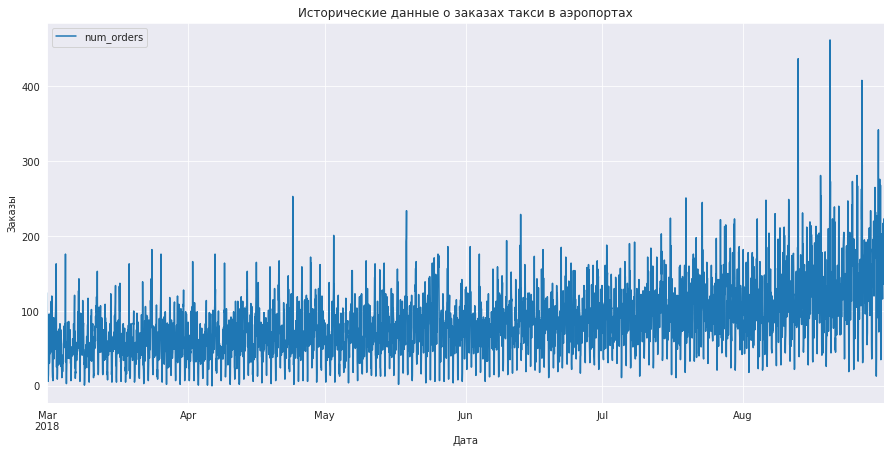

In [12]:
df.plot(figsize=(15, 7))
plt.title('Исторические данные о заказах такси в аэропортах')
plt.xlabel('Дата')
plt.ylabel('Заказы')
plt.show()

Пропусков нет, индекс монотонно возрастает, отсортирован.
Произвели ресемплирование - промежуток - 1 час, агрегацию проводили с помощью метода sum()

Можем переходить к анализу

## Анализ

#### Скользящее среднее и скользящее стандартное отклонение

Найдем cреднее значение и стандартное отклонение

In [13]:
df["rolling_mean"] = df["num_orders"].rolling(20).mean()
df["rolling_std"] = df["num_orders"].rolling(20).std()

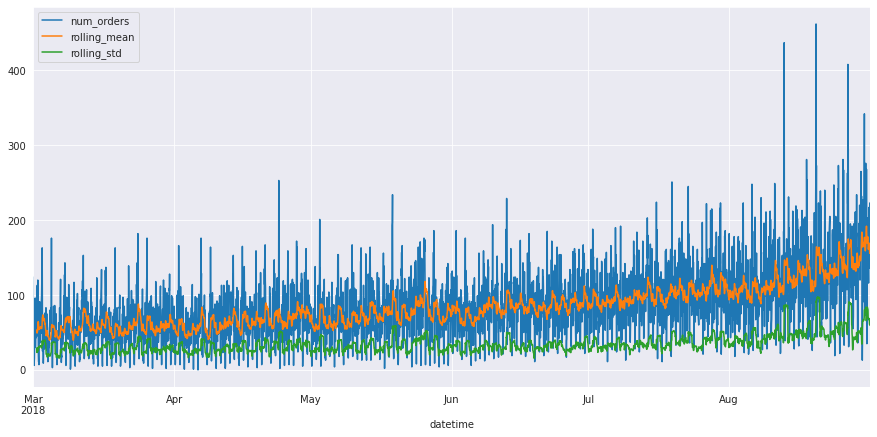

In [14]:
df.plot(figsize=(15, 7))
plt.show()

незначительный рост стандартного отклонения, его колебания как и незначительный рост среднего, значит временной ряд нестационарный. посмотрим ли сильно измениться ситуация, если получить разность ряда

#### Разность временного ряда

In [15]:
df_new = df - df.shift()

In [16]:
df_new["rolling_mean"] = df_new["num_orders"].rolling(20).mean()
df_new["rolling_std"] = df_new["num_orders"].rolling(20).std()

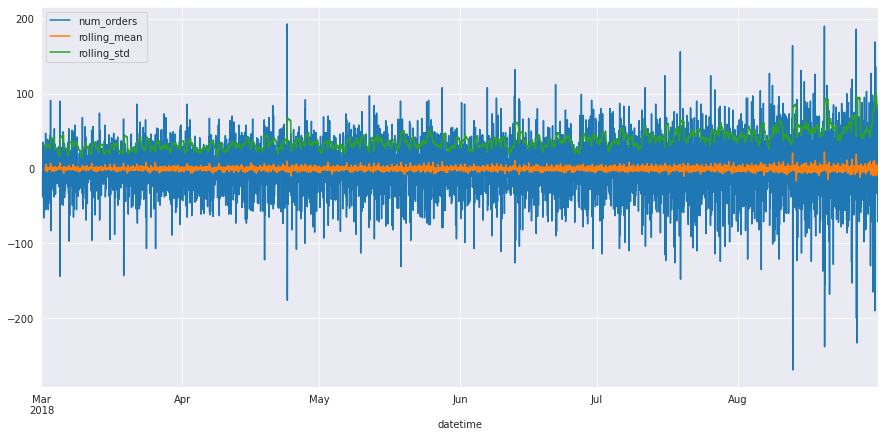

In [17]:
df_new.plot(figsize=(15, 7))
plt.show()

Ряд стал более стационарным

In [18]:
df_new.describe()

,num_orders,rolling_mean,rolling_std
count,4415.000000,4396.000000,4396.000000
mean,0.018347,0.024488,37.989795
std,39.023437,2.801253,12.318616
min,-269.000000,-16.650000,14.839049
25%,-22.000000,-1.750000,29.647457
50%,1.000000,-0.050000,35.859650
75%,23.000000,1.650000,43.480720
max,193.000000,21.800000,100.717675


Если значение с индексом 1 меньше P-Value,(обычно 0.05), то ряд стационарный

In [19]:
ts = df['num_orders']
st_test = adfuller(ts, regression='ctt')

if st_test[1] < 0.05:
    print('Временной ряд стационарный')
else:
    print('Временной ряд нестационарный')

Временной ряд стационарный


<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Классно, что сделал тест Дики-Фуллера! Ряд стационарен, отлично!
</div>

#### Тренды и сезонность

Проведем декомпозицию для просмотра тренда и сезонности

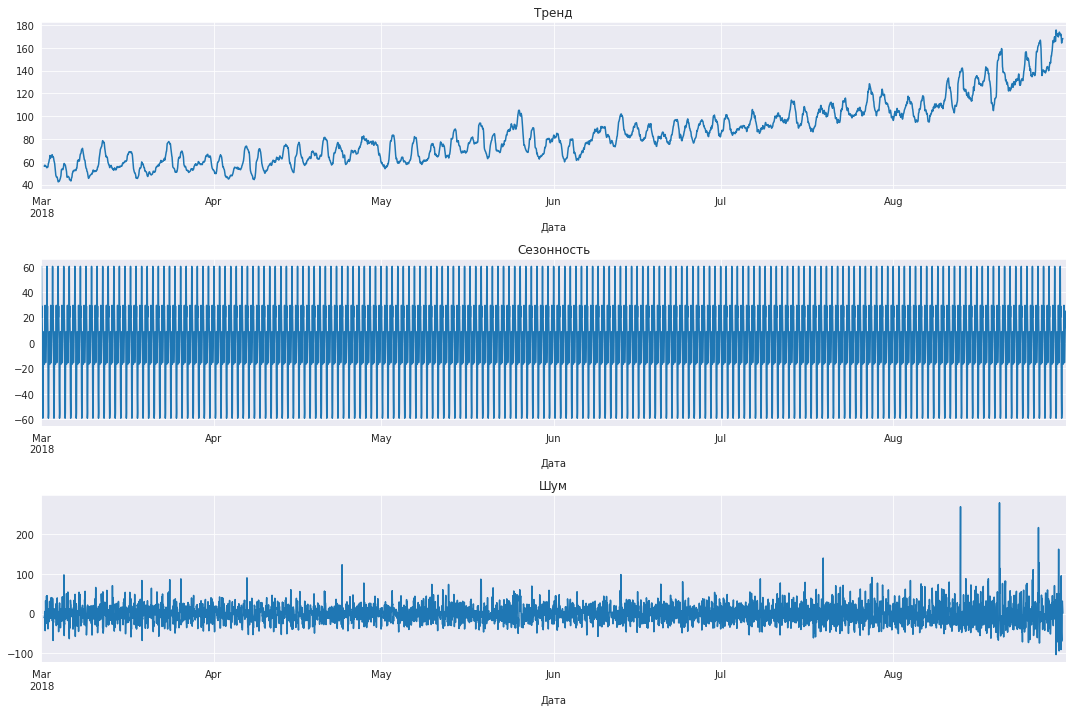

In [20]:
decomposed = seasonal_decompose(df["num_orders"])
plt.figure(figsize=(15, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата')


plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Сезонность')
plt.xlabel('Дата')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Шум')
plt.xlabel('Дата')

plt.tight_layout()

Тренд восходящий, сезонности как таковой не наблюдается, рассмотрим сезонность на меньшем временном промежутке

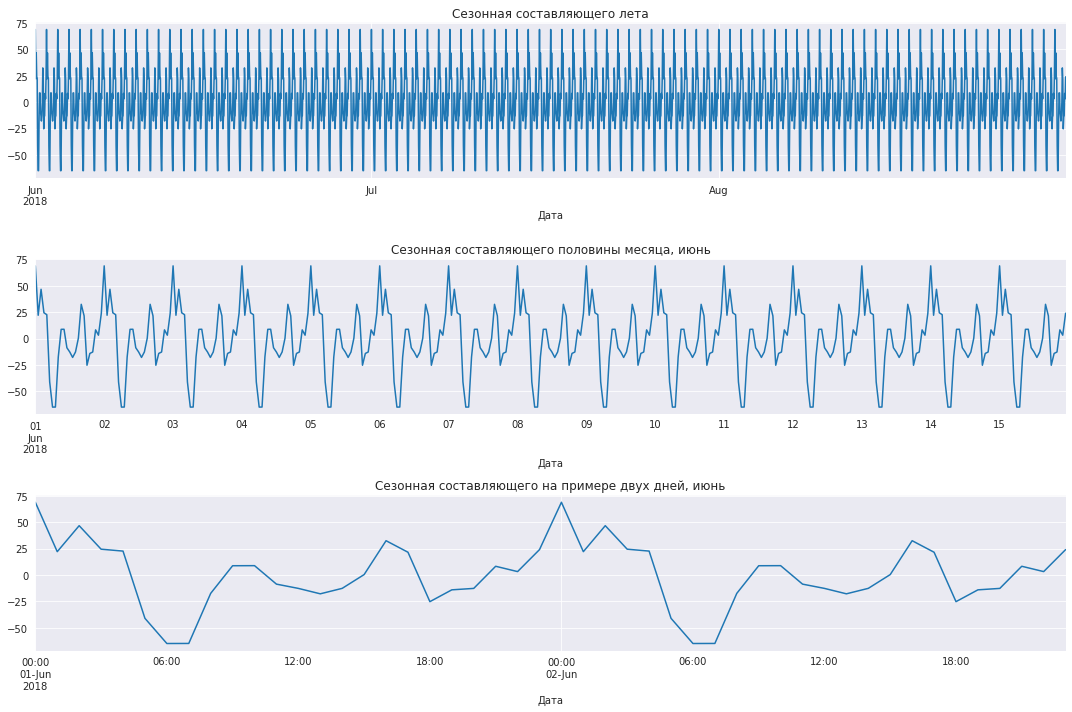

In [21]:
plt.figure(figsize=(15, 10))
summer = df['2018-06':'2018-08']['num_orders']
decomposed = seasonal_decompose(summer)

plt.subplot(311)
decomposed.seasonal['2018-06-01':'2018-08-31'].plot(ax=plt.gca())
plt.xlabel('Дата')
plt.title('Сезонная составляющего лета')

plt.subplot(312)
decomposed.seasonal['2018-06-01':'2018-06-15'].plot(ax=plt.gca())
plt.title('Сезонная составляющего половины месяца, июнь')
plt.xlabel('Дата')

plt.subplot(313)
decomposed.seasonal['2018-06-01':'2018-06-02'].plot(ax=plt.gca())
plt.title('Сезонная составляющего на примере двух дней, июнь')
plt.xlabel('Дата')


plt.tight_layout()

Сезонность привязана к времени суток.Количество заказов зависит от распорядка дня клиентов. Пик пользования такси - полночь. Также популярность высокая в начале и конце рабочего времени, когда большинство людей соответсвенно едут на работу и с работы.

**Вывод**

Выявили сезонность связанную с веременем суток, посмотрели разницу временного ряда - после преобразования он стал более стационарным - значит данные можно прогнозировать.

## Обучение

In [22]:
df.head()

,num_orders,rolling_mean,rolling_std
datetime,,,
2018-03-01 00:00:00,124,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN


Удалим вспомогательные признаки 

In [23]:
df = df.drop(['rolling_mean','rolling_std'], axis=1)
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


Создадим дополнительные и календарные признаки

In [24]:
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    data['dayofweek'] = data.index.dayofweek
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [25]:
data = make_features(df, 49, 1)

In [26]:
train, test = train_test_split(data, shuffle = False, random_state = 42, test_size = 0.2)
valid, test = train_test_split(test, shuffle = False, random_state = 42, test_size = 0.5)

In [27]:
train = train.dropna()

In [28]:
(train_features,
valid_features,
test_features) = (train.drop('num_orders',axis = 1),
                  valid.drop('num_orders',axis = 1),
                  test.drop('num_orders',axis = 1))
(train_target,
valid_target,
test_target) = (train['num_orders'],
                valid['num_orders'],
                test['num_orders'])

In [29]:
train_features

,dayofweek,day,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 01:00:00,5,3,1,163.0,72.0,119.0,101.0,93.0,49.0,89.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,163.0
2018-03-03 02:00:00,5,3,2,108.0,163.0,72.0,119.0,101.0,93.0,49.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,108.0
2018-03-03 03:00:00,5,3,3,25.0,108.0,163.0,72.0,119.0,101.0,93.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,25.0
2018-03-03 04:00:00,5,3,4,64.0,25.0,108.0,163.0,72.0,119.0,101.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,64.0
2018-03-03 05:00:00,5,3,5,44.0,64.0,25.0,108.0,163.0,72.0,119.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-07-25 23:00:00,2,25,23,84.0,110.0,111.0,137.0,68.0,121.0,134.0,...,30.0,66.0,104.0,144.0,101.0,149.0,165.0,79.0,104.0,84.0
2018-07-26 00:00:00,3,26,0,138.0,84.0,110.0,111.0,137.0,68.0,121.0,...,103.0,30.0,66.0,104.0,144.0,101.0,149.0,165.0,79.0,138.0
2018-07-26 01:00:00,3,26,1,149.0,138.0,84.0,110.0,111.0,137.0,68.0,...,68.0,103.0,30.0,66.0,104.0,144.0,101.0,149.0,165.0,149.0


In [30]:
splits = TimeSeriesSplit(n_splits=8)

**RandomForest**

In [31]:
%%time
RF = RandomForestRegressor(random_state=42)
params = {"max_depth": [1,10],"n_estimators":[100,150,10]}

RF_grid = GridSearchCV(RF, params, cv = splits, verbose=True, n_jobs=-1)
RF_grid.fit(train_features,train_target)

Fitting 8 folds for each of 6 candidates, totalling 48 fits
CPU times: user 1min 16s, sys: 128 ms, total: 1min 16s
Wall time: 1min 16s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=8, test_size=None),
             estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [1, 10], 'n_estimators': [100, 150, 10]},
             verbose=True)

**CatBoost**

In [32]:
catboost = CatBoostRegressor(loss_function='RMSE',random_state = 42)
params_cat = {'depth':[5,10], 'learning_rate':np.arange(0.1,1,0.2)}
catboost_grid = catboost.grid_search(params_cat,
            Pool(train_features,train_target),cv=splits,verbose=True)

0:	learn: 70.1653928	test: 95.3487939	best: 95.3487939 (0)	total: 55.2ms	remaining: 55.2s
1:	learn: 64.5596603	test: 88.8922331	best: 88.8922331 (1)	total: 61.7ms	remaining: 30.8s
2:	learn: 59.3087891	test: 82.4132012	best: 82.4132012 (2)	total: 67.7ms	remaining: 22.5s
3:	learn: 54.6358947	test: 77.0064285	best: 77.0064285 (3)	total: 73.6ms	remaining: 18.3s
4:	learn: 50.4135725	test: 71.5142505	best: 71.5142505 (4)	total: 79.4ms	remaining: 15.8s
5:	learn: 46.7034467	test: 67.0930516	best: 67.0930516 (5)	total: 85.5ms	remaining: 14.2s
6:	learn: 43.4248574	test: 62.6065610	best: 62.6065610 (6)	total: 91.4ms	remaining: 13s
7:	learn: 40.5012979	test: 59.4232079	best: 59.4232079 (7)	total: 97ms	remaining: 12s
8:	learn: 37.8471762	test: 55.6753585	best: 55.6753585 (8)	total: 103ms	remaining: 11.3s
9:	learn: 35.6254110	test: 52.5915578	best: 52.5915578 (9)	total: 109ms	remaining: 10.8s
10:	learn: 33.6787859	test: 49.7555798	best: 49.7555798 (10)	total: 115ms	remaining: 10.3s
11:	learn: 31.929

**LightGBM**

In [33]:
%%time

lgb_train = lgb.Dataset(train_features,train_target)
lgb_valid = lgb.Dataset(valid_features,valid_target, reference=lgb_train)
parameters_light = {'metric': 'l2', 'max_depth':10,"random_state": 42,"learning_rate":0.1}
light = lgb.train(parameters_light,
                lgb_train,
                num_boost_round=1000,
                valid_sets=[lgb_train,lgb_valid],
                verbose_eval=100)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.198731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8863
[LightGBM] [Info] Number of data points in the train set: 3483, number of used features: 53
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score 74.482056
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits w

In [34]:
%%time
final_cat = CatBoostRegressor(depth=catboost_grid["params"]["depth"], 
                              learning_rate=catboost_grid["params"]['learning_rate'],
                              loss_function='RMSE',verbose=100)
final_cat.fit(Pool(train_features,train_target))

0:	learn: 34.0173254	total: 7.47ms	remaining: 7.46s
100:	learn: 18.4327716	total: 617ms	remaining: 5.5s
200:	learn: 15.9254600	total: 1.18s	remaining: 4.7s
300:	learn: 14.0161919	total: 1.75s	remaining: 4.07s
400:	learn: 12.4241076	total: 2.36s	remaining: 3.52s
500:	learn: 11.1388084	total: 2.98s	remaining: 2.96s
600:	learn: 10.0132070	total: 3.56s	remaining: 2.37s
700:	learn: 8.9773614	total: 4.18s	remaining: 1.78s
800:	learn: 8.1366197	total: 4.78s	remaining: 1.19s
900:	learn: 7.3319749	total: 5.36s	remaining: 589ms
999:	learn: 6.6277619	total: 5.96s	remaining: 0us
CPU times: user 6.04 s, sys: 107 ms, total: 6.15 s
Wall time: 6.97 s


- лучшие гиперпараметры определены
- модели обучены


## Тестирование

**RandomForest**

In [35]:
# Valid
preds_RF_valid = RF_grid.best_estimator_.predict(valid_features)
# Test
RF_test_start_time = time.time()
preds_RF_test = RF_grid.best_estimator_.predict(test_features)
RF_test_total_time = time.time() - RF_test_start_time
# Train
preds_RF_train = RF_grid.best_estimator_.predict(train_features)

# RMSE
RMSE_RF_train = (mean_squared_error(train_target,preds_RF_train))**0.5
RMSE_RF_valid = (mean_squared_error(valid_target,preds_RF_valid))**0.5
RMSE_RF_test = (mean_squared_error(test_target,preds_RF_test))**0.5

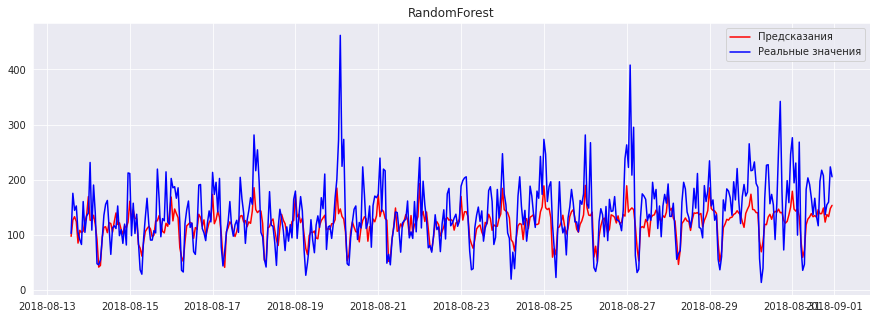

In [36]:
plt.figure(figsize=(15,5))
plt.title('RandomForest')

plt.plot(test_target.index, preds_RF_test, 'r', label='Предсказания')
plt.plot(test_target.index, test_target.values, 'b', label='Реальные значения')
plt.legend()
plt.show()

**CatBoost**

In [37]:
preds_Cat_valid = final_cat.predict(valid_features)

In [38]:
CatBoost_test_start_time = time.time()
preds_Cat_test = final_cat.predict(test_features)
CatBoost_test_total_time = time.time() - CatBoost_test_start_time

In [39]:
preds_Cat_train = final_cat.predict(train_features)

In [40]:
RMSE_CatBoost_train = (mean_squared_error(train_target,preds_Cat_train))**0.5
RMSE_CatBoost_valid = (mean_squared_error(valid_target,preds_Cat_valid))**0.5
RMSE_CatBoost_test = (mean_squared_error(test_target,preds_Cat_test))**0.5

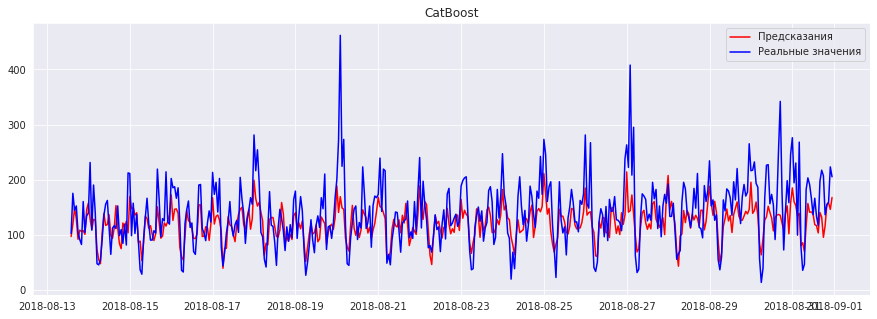

In [41]:
plt.figure(figsize=(15,5))
plt.title('CatBoost')

plt.plot(test_target.index, preds_Cat_test, 'r', label='Предсказания')
plt.plot(test_target.index, test_target.values, 'b', label='Реальные значения')
plt.legend()

plt.show()


**LightGBM**

In [42]:
preds_Light_valid = light.predict(valid_features)

In [43]:
LightGBM_test_start_time = time.time()
preds_Light_test = light.predict(test_features)
LightGBM_test_total_time = time.time() - LightGBM_test_start_time

In [44]:
preds_Light_train = light.predict(train_features)

In [45]:
RMSE_LightGBM_train = (mean_squared_error(train_target,preds_Light_train))**0.5
RMSE_LightGBM_valid = (mean_squared_error(valid_target,preds_Light_valid))**0.5
RMSE_LightGBM_test = (mean_squared_error(test_target,preds_Light_test))**0.5

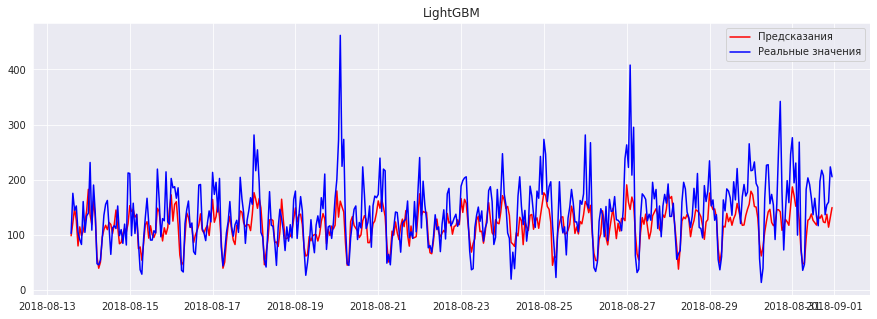

In [46]:
plt.figure(figsize=(15,5))
plt.title('LightGBM')

plt.plot(test_target.index, preds_Light_test, 'red', label='Предсказания')
plt.plot(test_target.index, test_target.values, 'b', label='Реальные значения')
plt.legend()
plt.show()

**ВЫВОД**

Таблица с метриками

In [47]:
summary = pd.DataFrame(columns = ["RandomForest","CatBoost","LightGBM"],
                      index = ["RMSE_train",
                               "RMSE_valid",
                               "RMSE_test",
                               "Время предсказания"])


summary.iloc[0] = [RMSE_RF_train,RMSE_CatBoost_train,RMSE_LightGBM_train]
summary.iloc[1] = [RMSE_RF_valid,RMSE_CatBoost_valid,RMSE_LightGBM_valid]
summary.iloc[2] = [RMSE_RF_test,RMSE_CatBoost_test,RMSE_LightGBM_test]
summary.iloc[3] = [RF_test_total_time,CatBoost_test_total_time,LightGBM_test_total_time]

In [48]:
summary 

,RandomForest,CatBoost,LightGBM
RMSE_train,12.344162,6.627762,0.156551
RMSE_valid,32.772133,31.129831,30.713543
RMSE_test,48.261971,46.902914,47.76278
Время предсказания,0.018455,0.011487,0.087386


Модели CatBoost и LightGBM показывают RMSE на тествой выборке меньше 48. Модель CatBoost дает лучший результат RMSE на тестовой выборке.

**Финальный вывод**

- В ходе проекта был проведен анализ временного ряда с данными о заказах такси в аэропортах.
- были добавлены дополнительные признаки. 
- Обучены разные модели с различными гиперпараметрами. 
- Путем проверки обученных моделей на тестовых выборках, было выявлено, что модель CatBoost дает лучшие показатели RMSE 46.902914.
